In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from typing import Iterable, Any, Tuple, Dict


# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score, balanced_accuracy_score, accuracy_score
from pathlib import Path


# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import preprocess_data as ppd
import GAMinferenceModels_V2 as gam_models

/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_90407/2611978516.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(x)


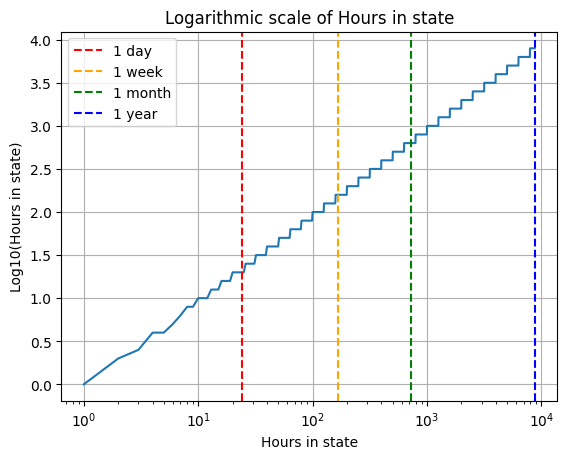

In [6]:
x = np.arange(24*365)
y = np.log10(x)
y = np.floor(y*10)/10  # Round down to nearest 0.1
plt.plot(x, y)
day = 24
week = 24*7
month = 24*30
year = 24*365
plt.xscale('log')
plt.axvline(day, color='red', linestyle='--', label='1 day')
plt.axvline(week, color='orange', linestyle='--', label='1 week')
plt.axvline(month, color='green', linestyle='--', label='1 month')
plt.axvline(year, color='blue', linestyle='--', label='1 year')
plt.xlabel('Hours in state')
plt.ylabel('Log10(Hours in state)')
plt.title('Logarithmic scale of Hours in state')
plt.legend()
plt.grid()
plt.show()

# Data

In [2]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/by_technology/hourly_failure_deltaTime_dataset_Combined_Cycle_Block.csv"

all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                        weather_data_path=weather_data_file,
                                                                                        power_load_data_path=power_load_file,
                                                                                        feature_names=['Temperature', 'Relative_humidity', 'Load', 'hours_in_state', 'State'],
                                                                                        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                        state_one_hot=False,
                                                                                        initial_MC_state_filter='all',
                                                                                        # technology_filter=['Gas Turbine/Jet Engine (Simple Cycle Operation)'],
                                                                                        test_periods=None
                                                                                        )

In [2]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/by_technology/hourly_failure_deltaTime_dataset_Gas_Turbine_Jet_Engine_(Simple_Cycle_Operation).csv"

all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                        weather_data_path=weather_data_file,
                                                                                        power_load_data_path=power_load_file,
                                                                                        feature_names=['Temperature', 'Relative_humidity', 'Load', 'hours_in_state', 'State'],
                                                                                        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                        state_one_hot=False,
                                                                                        initial_MC_state_filter='all',
                                                                                        # technology_filter=['Gas Turbine/Jet Engine (Simple Cycle Operation)'],
                                                                                        test_periods=None
                                                                                        )

(1) Loaded failure data
(2) Loaded weather data
(3) Loaded power load data
(4) Merged data shape after joining: (55662603, 13)
(5) Merged data shape after aggregation: (55662603, 11)
(6) State encoding applied. Current features: ['Load', 'Hours_in_state', 'Temperature', 'Relative_humidity', 'State', 'Initial_gen_state', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold']
(7) Technology encoding applied. Current features: ['Load', 'Hours_in_state', 'Temperature', 'Relative_humidity', 'State', 'Initial_gen_state', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold']
(8) Calendar features added. Current features: ['Load', 'Hours_in_state', 'Temperature', 'Relative_humidity', 'State', 'Initial_gen_state', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold']
(9) Target columns constructed. Current features: ['Load', 'Hours_in_state', 'Temperature', 'Relative_humidity', 'State', 'Initial_gen_state', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold']
(10) Cyclic feature encoding applied. Current f

In [ ]:
# weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
# power_load_file = "../Data/hourly/hourly_load_by_state.csv"
# failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

# all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
#                                                                                         weather_data_path=weather_data_file,
#                                                                                         power_load_data_path=power_load_file,
#                                                                                         feature_names=['Temperature', 'Relative_humidity', 'Load', 'hours_in_state', 'State'],
#                                                                                         cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
#                                                                                         state_one_hot=False,
#                                                                                         initial_MC_state_filter='all',
#                                                                                         # technology_filter=['Gas Turbine/Jet Engine (Simple Cycle Operation)'],
#                                                                                         test_periods=None
#                                                                                         )

In [10]:
# temporal features for regional classifiers
all_data_df['month_sin'] = np.sin(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)
all_data_df['month_cos'] = np.cos(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)

# Get list of states from one-hot encoded columns
idx2state = {v: k for k, v in integer_encoding['States'].items()}
all_data_df['State'] = all_data_df['State'].apply(lambda x: idx2state[x])
states_list = all_data_df['State'].unique().tolist()
states_list.sort()

In [11]:
# states_list = ['TEXAS', 'CALIFORNIA', 'FLORIDA', 'NEW YORK', 'ILLINOIS']
# states_list = ['TEXAS']
# states_list = states_list[31:]  # 2022-2023 testing
# states_list = states_list[40:]  # extreme cold event testing
# states_list = states_list[42:]  # extreme hot event testing
# if 'MASSACHUSETTS' in states_list:
#     states_list.remove('MASSACHUSETTS')
# states_list = ['MASSACHUSETTS']
print("States considered:", states_list)

States considered: ['ALABAMA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']


### 2022-2023 test

In [12]:
# general_test_period = [(pd.Timestamp('2022-01-01 00:00:00'), pd.Timestamp('2023-12-31 23:00:00'))]
general_test_period = [(pd.Timestamp('2022-01-01 00:00:00', tz='UTC'), pd.Timestamp('2023-12-31 23:00:00', tz='UTC'))]

specific_test_periods_per_state = {state: general_test_period for state in states_list}

folder_name = "2022_2023_test_periods_highReg"

### Test on extreme event

In [6]:
def detect_extreme_temperature_events(
    all_data_df: pd.DataFrame,
    states_list,
    *,
    temp_col="Temperature",
    datetime_col="Datetime_UTC",
    state_col="State",
    cold_percentile=5,
    hot_percentile=85,
    min_duration=2,
):
    """
    Detect extreme cold and hot events per state.

    Definitions
    -----------
    - Daily mean temperature computed from hourly data
    - Extreme cold: daily mean <= cold_percentile
    - Extreme hot : daily mean >= hot_percentile
    - Event = at least `min_duration` consecutive days
    - Events returned as (start_day, end_day), inclusive

    Returns
    -------
    extreme_cold_events_dt : dict[state -> list[(start_day, end_day)]]
    extreme_hot_events_dt  : dict[state -> list[(start_day, end_day)]]
    """

    extreme_cold_events_dt = defaultdict(list)
    extreme_hot_events_dt  = defaultdict(list)

    for state in states_list:
        # --- isolate state data ---
        state_data = (
            all_data_df.loc[all_data_df[state_col] == state, [datetime_col, temp_col]]
            .drop_duplicates(subset=[datetime_col])
            .sort_values(datetime_col)
            .copy()
        )

        if state_data.empty:
            continue

        # --- compute daily mean temperature ---
        state_data["Day"] = state_data[datetime_col].dt.floor("D")
        daily = (
            state_data
            .groupby("Day", as_index=False)[temp_col]
            .mean()
            .rename(columns={temp_col: "Daily_mean_Temperature"})
            .sort_values("Day")
        )

        temps = daily["Daily_mean_Temperature"].to_numpy()

        # --- thresholds ---
        cold_thr = np.percentile(temps, cold_percentile)
        hot_thr  = np.percentile(temps, hot_percentile)

        is_cold = temps <= cold_thr
        is_hot  = temps >= hot_thr

        # --- helper to extract runs ---
        def extract_runs(mask, days, min_len):
            """
            mask : boolean array
            days : array of day timestamps
            """
            runs = []
            d = np.diff(np.r_[0, mask.astype(int), 0])
            starts = np.where(d == 1)[0]
            ends   = np.where(d == -1)[0]  # exclusive

            for s, e in zip(starts, ends):
                if (e - s) >= min_len:
                    runs.append((days[s], days[e - 1]))  # inclusive end
            return runs

        days = daily["Day"].to_numpy()

        # --- extract events ---
        extreme_cold_events_dt[state] = extract_runs(
            is_cold, days, min_duration
        )
        extreme_hot_events_dt[state] = extract_runs(
            is_hot, days, min_duration
        )

    return extreme_cold_events_dt, extreme_hot_events_dt

def select_extreme_events(
        all_extreme_events: list[Tuple[pd.Timestamp, pd.Timestamp]],
        method: str = 'longest',
        n: int = 2
    ) -> list[Tuple[pd.Timestamp, pd.Timestamp]]:
    if method == 'longest':
        # Select the n longest events
        selected_events = sorted(all_extreme_events, key=lambda x: x[1] - x[0], reverse=True)[:n]
    else:
        raise ValueError(f"Invalid method {method}. Choose 'longest'.")
    return selected_events

In [ ]:
# n_cold = 1
# n_hot = 1

# extreme_cold_events, extreme_hot_events = detect_extreme_temperature_events(
#     all_data_df,
#     states_list,
#     temp_col="Temperature",
#     datetime_col="Datetime_UTC",
#     state_col="State",
#     cold_percentile=5,
#     hot_percentile=95,
#     min_duration=2,
# )

# selected_cold_events = {
#     state: select_extreme_events(events, method='longest', n=n_cold)
#     for state, events in extreme_cold_events.items()}
# selected_hot_events = {
#     state: select_extreme_events(events, method='longest', n=n_hot)
#     for state, events in extreme_hot_events.items()}

# round_of_cold_events = {i: {state: [events[i]] for state, events in selected_cold_events.items() if events} for i in range(n_cold)}
# round_of_hot_events = {i: {state: [events[i]] for state, events in selected_hot_events.items() if events} for i in range(n_hot)}

# folder_name_cold = "Extreme_cold_events"
# folder_name_hot = "Extreme_hot_events"

# Regional classifiers

In [ ]:
classifier_features = ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos']

In [ ]:
def get_region_classifier_split(all_data_df, region, test_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)

    all_data_df = all_data_df.drop_duplicates(subset=['Datetime_UTC', 'State']).copy()

    df = all_data_df.copy()
    df["is_region"] = (df["State"] == region).astype(int)

    # indices for positives and negatives
    pos_idx = df.index[df["is_region"] == 1].to_numpy()
    neg_idx = df.index[df["is_region"] == 0].to_numpy()

    n_pos_te = int(len(pos_idx) * test_frac)
    n_neg_te = int(len(neg_idx) * test_frac)
    pos_te = rng.choice(pos_idx, size=n_pos_te, replace=False)
    neg_te = rng.choice(neg_idx, size=n_neg_te, replace=False)
    

    test_idx = np.unique(np.concatenate([pos_te, neg_te]))
    train_idx = df.index.difference(test_idx)

    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df  = df.loc[test_idx].reset_index(drop=True)
    train_df['Load_CDF'] = ppd.load_cdf(train_df, train_df)
    test_df['Load_CDF'] = ppd.load_cdf(train_df, test_df)
    return train_df, test_df

In [ ]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [ ]:
cls_nll = {}
naive_nll = {}
roc_auc = {}
regional_models = {}

eps = 1e-15  # for numerical safety

for region in tqdm(states_list, desc="Regions"):
    train_state_df, test_state_df = get_region_classifier_split(all_data_df, region)

    # fit
    region_model = gam_models.regional_classifier(
        train_data=train_state_df,
        region=region,
        classifier_feats=classifier_features,
    )
    regional_models[region] = region_model

    # ----- evaluation -----
    X_te = test_state_df[classifier_features]
    y_te = test_state_df["is_region"].to_numpy()

    # model predicted probability of being in region
    p_te = region_model.predict_proba(X_te)[:, 1]
    p_te = np.clip(p_te, eps, 1 - eps)

    # naive constant probability using TRAIN prevalence (fair baseline)
    p0 = train_state_df["is_region"].mean()
    p0 = float(np.clip(p0, eps, 1 - eps))
    p_naive = np.full(y_te.shape, p0, dtype=float)

    # roc auc
    roc_auc[region] = roc_auc_score(y_te, p_te)

    cls_nll[region] = log_loss(y_te, p_te, labels=[0, 1])
    naive_nll[region] = log_loss(y_te, p_naive, labels=[0, 1])

Regions: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


In [ ]:
def plot_delta_nll_by_region(delta_nll_dict, figsize=(14, 6),
                            title="Regional classifier improvement over naive baseline",
                            ylabel="Δ NLL (Naive − Model)", fontsize=14, ticksize=12):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    df = pd.DataFrame({"region": list(delta_nll_dict.keys()),
                       "delta": list(delta_nll_dict.values())}).sort_values("delta", ascending=False)

    regions = df["region"].values
    delta = df["delta"].values
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)

    colors = ["#2ca02c" if d > 0 else "#d62728" for d in delta]
    bars = ax.bar(x, delta, color=colors, alpha=0.9)

    ax.axhline(0, color="black", linewidth=1.2, linestyle="--")
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha="right", fontsize=ticksize)



    ax.grid(axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(handles=[
        Patch(facecolor="#2ca02c", label="Better than baseline"),
        Patch(facecolor="#d62728", label="Worse than baseline"),
    ], frameon=False)

    plt.tight_layout()
    plt.show()


def plot_roc_auc_by_region(roc_auc_dict, figsize=(14, 6),
                           title="Regional classifier ROC AUC",
                           ylabel="ROC AUC", fontsize=14, ticksize=12, sort=True):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    df = pd.DataFrame({"region": list(roc_auc_dict.keys()),
                       "auc": list(roc_auc_dict.values())})

    if sort:
        df = df.sort_values("auc", ascending=False)

    regions = df["region"].values
    auc_vals = df["auc"].values
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)

    colors = ["#2ca02c" if a > 0.5 else "#d62728" for a in auc_vals]
    bars = ax.bar(x, auc_vals, color=colors, alpha=0.9)

    ax.axhline(0.5, color="black", linewidth=1.2, linestyle="--")
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha="right", fontsize=ticksize)
    ax.set_ylim(0.49, 1.0)


    ax.grid(axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(handles=[
        Patch(facecolor="#2ca02c", label="Better than random (AUC > 0.5)"),
        Patch(facecolor="#d62728", label="Worse than random (AUC ≤ 0.5)"),
    ], frameon=False)

    plt.tight_layout()
    plt.show()

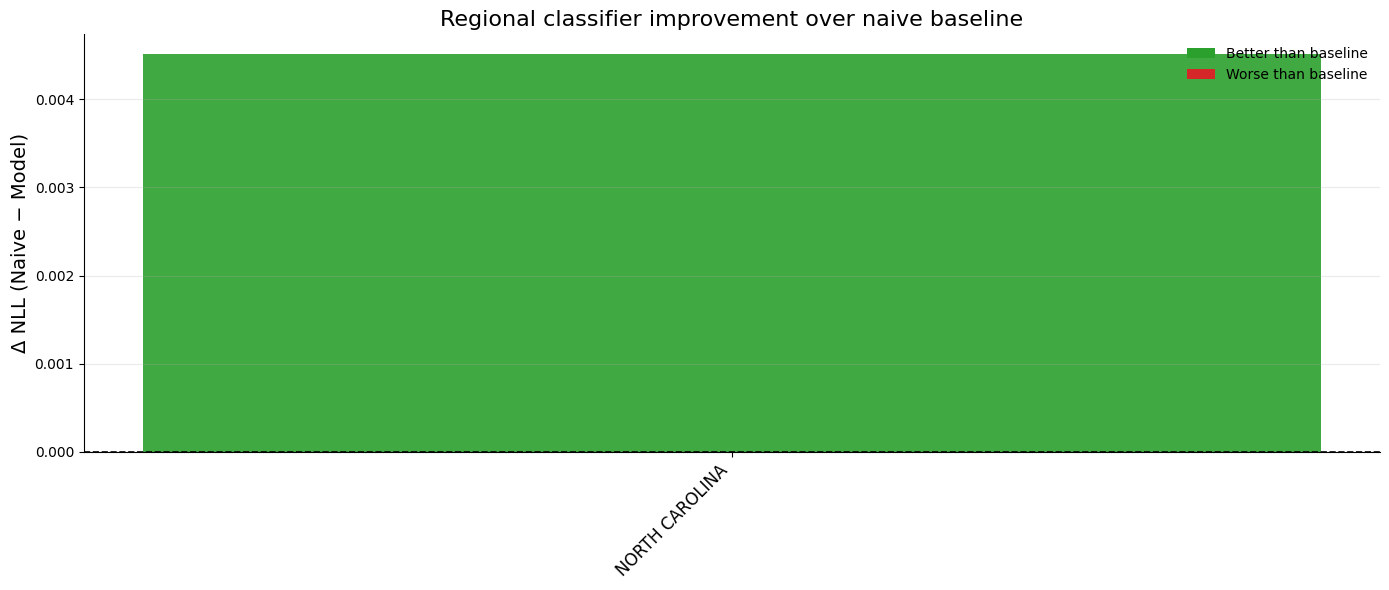

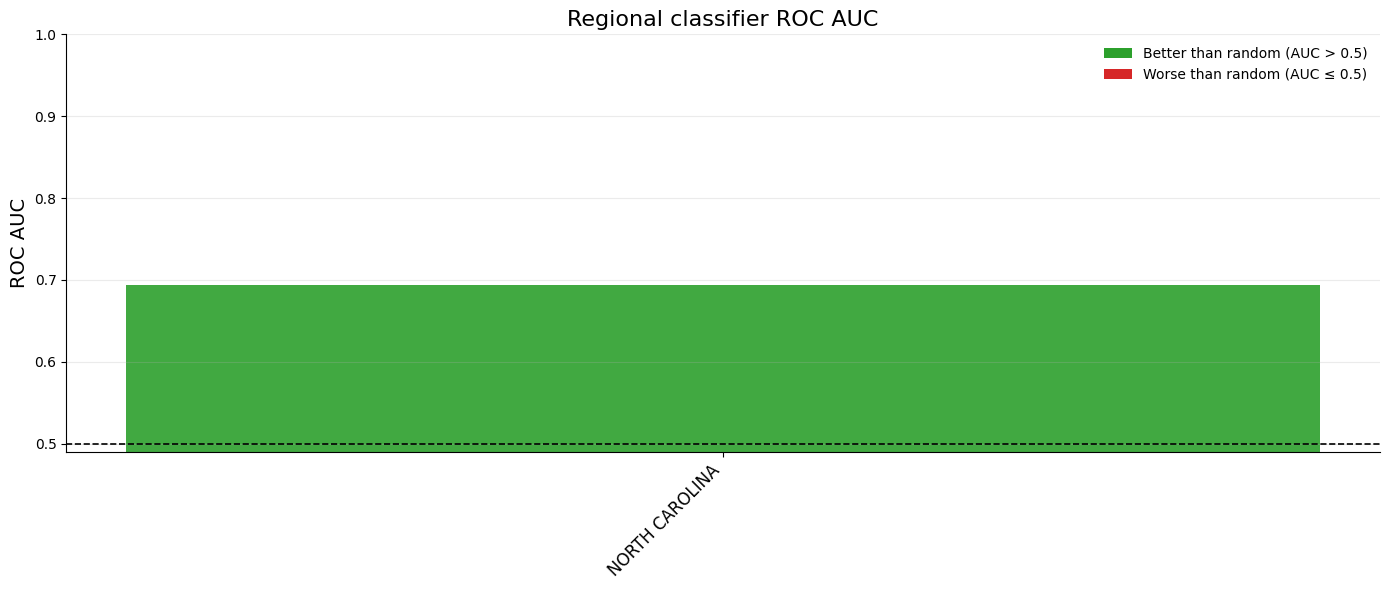

In [ ]:
delta_nll = {r: naive_nll[r] - cls_nll[r] for r in cls_nll}


plot_delta_nll_by_region(delta_nll)

plot_roc_auc_by_region(roc_auc)

# Train random split

In [15]:
importlib.reload(gam_models)
spline_version = '_SMC_5sALL_'

In [14]:
gamma = 0.5
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4', 'Hours_in_state']
# base_model_factory = gam_models.make_gam_factory_spline_only(
#     n_features=len(feature_cols),
#     n_splines=10,
# )

In [ ]:
for state_nb, state in tqdm(enumerate(states_list), total=len(states_list), desc="Training all states..."):
    if state_nb<28:
        continue
    transition_models_full, train_datasets_full, test_datasets_full, ess_res_full, scalers_full = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= [state],
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='GAM',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_full,
        test_datasets= test_datasets_full,
        cols_export=['Datetime_UTC', 'Stress', 'Initial_gen_state', 'Final_gen_state', 'Data_weight', 'pAD', 'pAO', 'pDA', 'pOA'],
        region_only=True,
        test=True,
        feature_cols= feature_cols,
        scalers_by_region= scalers_full,
        out_dir=f'../Results/GAM/{folder_name}/full{spline_version}/',
        model_name='full'
    )
    transition_models_As, train_datasets_As, test_datasets_As, ess_res_As, scalers_As = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= [state],
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='GAM',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= False,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_As,
        test_datasets= test_datasets_As,
        cols_export=['Datetime_UTC', 'Stress', 'Initial_gen_state', 'Final_gen_state', 'Data_weight', 'pAD', 'pAO', 'pDA', 'pOA'],
        region_only=True,
        scalers_by_region= scalers_As,
        feature_cols= feature_cols,
        test=True,
        out_dir=f'../Results/GAM/{folder_name}/As{spline_version}/',
        model_name='As'
    )
                                                                           


In [ ]:
transition_models_full, train_datasets_full, test_datasets_full, ess_res_full, scalers_full = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='GAM',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
                                                                           

In [ ]:
gam_models.export_gam_predictions(
    transition_models= transition_models_full,
    test_datasets= test_datasets_full,
    test=True,
    feature_cols= feature_cols,
    scalers_by_region= scalers_full,
    out_dir=f'../Results/GAM/{folder_name}/full/',
    model_name='full'
)

[OK] wrote ../Results/GAM/2022_2023_test_periods/full/GAM_full_results_test_TEXAS.csv | n=1586586


In [29]:
# gam_models.export_gam_predictions(
#     transition_models= transition_models_full,
#     test_datasets= train_datasets_full,
#     test=False,
#     feature_cols= feature_cols,
#     scalers_by_region= scalers_full,
#     out_dir=f'../Results/GAM/{folder_name}/full/',
#     model_name='full'
# )

[OK] wrote ../Results/GAM/2022_2023_test_periods/full/GAM_full_results_train_TEXAS.csv | n=5358364


In [16]:
transition_models_Ar, train_datasets_Ar, test_datasets_Ar, ess_res_Ar, scalers_Ar = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list[:1],
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='GAM',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= False,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)

: 

In [10]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [ ]:
gam_models.export_gam_predictions(
    transition_models= transition_models_Ar,
    test_datasets= test_datasets_Ar,
    scalers_by_region= scalers_Ar,
    cols_export=['Datetime_UTC', 'State', 'Stress', 'Initial_gen_state', 'Final_gen_state', 'Data_weight', 'pAD', 'pAO', 'pDA', 'pOA'],
    region_only=False,
    test=True,
    feature_cols= feature_cols,
    out_dir=f'../Results/GAM/{folder_name}/Ar{spline_version}/',
    model_name='Ar'
)

[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/Ar_20sALL_/GAM_Ar_results_test_ALABAMA.csv | n=1586586


In [32]:
# gam_models.export_gam_predictions(
#     transition_models= transition_models_Ar,
#     test_datasets= train_datasets_Ar,
#     scalers_by_region= scalers_Ar,
#     test=False,
#     feature_cols= feature_cols,
#     out_dir=f'../Results/GAM/{folder_name}/Ar/',
#     model_name='Ar'
# )

[OK] wrote ../Results/GAM/2022_2023_test_periods/Ar/GAM_Ar_results_train_TEXAS.csv | n=5358364


In [25]:
transition_models_As, train_datasets_As, test_datasets_As, ess_res_As, scalers_As = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='GAM',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= False,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)

Training regions: 100%|██████████| 1/1 [05:59<00:00, 359.99s/it]


In [26]:
gam_models.export_gam_predictions(
    transition_models= transition_models_As,
    test_datasets= test_datasets_As,
    scalers_by_region= scalers_As,
    feature_cols= feature_cols,
    test=True,
    out_dir=f'../Results/GAM/{folder_name}/As/',
    model_name='As'
)

[OK] wrote ../Results/GAM/2022_2023_test_periods/As/GAM_As_results_test_TEXAS.csv | n=1586586


In [27]:
# gam_models.export_gam_predictions(
#     transition_models= transition_models_As,
#     test_datasets= train_datasets_As,
#     scalers_by_region= scalers_As,
#     feature_cols= feature_cols,
#     test=False,
#     out_dir=f'../Results/GAM/{folder_name}/As/',
#     model_name='As'
# )

[OK] wrote ../Results/GAM/2022_2023_test_periods/As/GAM_As_results_train_TEXAS.csv | n=5358364


In [ ]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [14]:
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']

base_model_factory = gam_models.make_sklearn_logistic_factory(
    feature_cols= feature_cols,
    scale_cols=['Temperature', 'psi1', 'psi2', 'psi3', 'psi4'],
    passthrough_cols=['Load_CDF']
)


transition_models_logisticReg, train_datasets_logisticReg, test_datasets_logisticReg, ess_res_logisticReg, scalers_logisticReg = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            # base_model_factory= base_model_factory,
                                                                            type_model='LogisticRegression',
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= specific_test_periods_per_state,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)

In [16]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

In [17]:
gam_models.export_gam_predictions(
    transition_models= transition_models_logisticReg,
    test_datasets= test_datasets_logisticReg,
    scalers_by_region= scalers_logisticReg,
    cols_export=['Datetime_UTC', 'State', 'Stress', 'Initial_gen_state', 'Final_gen_state', 'Data_weight', 'pAD', 'pAO', 'pDA', 'pOA'],
    region_only=True,
    test=True,
    feature_cols= feature_cols,
    out_dir=f'../Results/GAM/{folder_name}/LogisticReg/',
    model_name='LogisticReg'
)

[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_ALABAMA.csv | n=26799
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_ARIZONA.csv | n=44870
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_ARKANSAS.csv | n=24046
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_CALIFORNIA.csv | n=54699
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_COLORADO.csv | n=32500
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_CONNECTICUT.csv | n=23008
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_DELAWARE.csv | n=37035
[OK] wrote ../Results/GAM/2022_2023_test_periods_highReg/LogisticReg/GAM_LogisticReg_results_test_FLORIDA.csv | n=50097
[OK] wrote ../Results/GAM/2022

# Train extreme events out

In [ ]:
gamma = 0.5
feature_cols = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']

## cold

In [ ]:
for i, cold_events in round_of_cold_events.items():
    base_model_factory_gam = gam_models.make_gam_factory_spline_only(
    n_features=len(feature_cols),
    n_splines=10,
)
    
    print(f"Training GAM models for cold event round {i}")
    transition_models_full, test_datasets_full, ess_res_full, scalers_full = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                                regions= states_list,
                                                                                feature_cols= feature_cols,
                                                                                zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                                regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                                base_model_factory= base_model_factory_gam,
                                                                                test_frac= 0.2,
                                                                                specific_test_periods= cold_events,
                                                                                seed= 42,
                                                                                w_region_consider= True,
                                                                                w_stress_consider= True,
                                                                                gamma= gamma,
                                                                                clipping_quantile= 0.95,
                                                                                verbose= False)
    
    gam_models.export_gam_predictions(
        transition_models= transition_models_full,
        test_datasets= test_datasets_full,
        feature_cols= feature_cols,
        scalers_by_region= scalers_full,
        out_dir=f'../Results/GAM/{folder_name_cold}/full/',
        model_name=f'full_cold{i}'
    )

    transition_models_Ar, test_datasets_Ar, ess_res_Ar, scalers_Ar = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_gam,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= cold_events,
                                                                            seed= 42,
                                                                            w_region_consider= False,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_Ar,
        test_datasets= test_datasets_Ar,
        scalers_by_region= scalers_Ar,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_cold}/Ar/',
        model_name=f'Ar_cold{i}'
    )

    transition_models_As, test_datasets_As, ess_res_As, scalers_As = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_gam,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= cold_events,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= False,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_As,
        test_datasets= test_datasets_As,
        scalers_by_region= scalers_As,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_cold}/As/',
        model_name=f'As_cold{i}'
    )

    base_model_factory_Logistic = gam_models.make_sklearn_logistic_factory(
        feature_cols= feature_cols,
        scale_cols=['Temperature', 'psi1', 'psi2', 'psi3', 'psi4'],
        passthrough_cols=['Load_CDF']
        )

    transition_models_logisticReg, test_datasets_logisticReg, ess_res_logisticReg, scalers_logisticReg = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_Logistic,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= cold_events,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_logisticReg,
        test_datasets= test_datasets_logisticReg,
        scalers_by_region= scalers_logisticReg,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_cold}/LogisticReg/',
        model_name=f'LogisticReg_cold{i}'
    )
                                                                           

## Hot events

In [ ]:
for i, hot_events in round_of_hot_events.items():
    base_model_factory_gam = gam_models.make_gam_factory_spline_only(
    n_features=len(feature_cols),
    n_splines=10,
)
    print(f"Training GAM models for hot event round {i}")
    transition_models_full, test_datasets_full, ess_res_full, scalers_full = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                                regions= states_list,
                                                                                feature_cols= feature_cols,
                                                                                zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                                regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                                base_model_factory= base_model_factory_gam,
                                                                                test_frac= 0.2,
                                                                                specific_test_periods= hot_events,
                                                                                seed= 42,
                                                                                w_region_consider= True,
                                                                                w_stress_consider= True,
                                                                                gamma= gamma,
                                                                                clipping_quantile= 0.95,
                                                                                verbose= False)
    
    gam_models.export_gam_predictions(
        transition_models= transition_models_full,
        test_datasets= test_datasets_full,
        feature_cols= feature_cols,
        scalers_by_region= scalers_full,
        out_dir=f'../Results/GAM/{folder_name_hot}/full/',
        model_name=f'full_hot{i}'
    )

    transition_models_Ar, test_datasets_Ar, ess_res_Ar, scalers_Ar = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_gam,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= hot_events,
                                                                            seed= 42,
                                                                            w_region_consider= False,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_Ar,
        test_datasets= test_datasets_Ar,
        scalers_by_region= scalers_Ar,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_hot}/Ar/',
        model_name=f'Ar_hot{i}'
    )

    transition_models_As, test_datasets_As, ess_res_As, scalers_As = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_gam,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= hot_events,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= False,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_As,
        test_datasets= test_datasets_As,
        scalers_by_region= scalers_As,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_hot}/As/',
        model_name=f'As_hot{i}'
    )

    base_model_factory_Logistic = gam_models.make_sklearn_logistic_factory(
        feature_cols= feature_cols,
        scale_cols=['Temperature', 'psi1', 'psi2', 'psi3', 'psi4'],
        passthrough_cols=['Load_CDF']
    )

    transition_models_logisticReg, test_datasets_logisticReg, ess_res_logisticReg, scalers_logisticReg = gam_models.train_all_region_transition_models( all_data_df= all_data_df,
                                                                            regions= states_list,
                                                                            feature_cols= feature_cols,
                                                                            zscore_cols=["Temperature", "psi1", "psi2", "psi3", "psi4"],
                                                                            regional_classifier_features= ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos'],
                                                                            base_model_factory= base_model_factory_Logistic,
                                                                            test_frac= 0.2,
                                                                            specific_test_periods= hot_events,
                                                                            seed= 42,
                                                                            w_region_consider= True,
                                                                            w_stress_consider= True,
                                                                            gamma= gamma,
                                                                            clipping_quantile= 0.95,
                                                                            verbose= False)
    gam_models.export_gam_predictions(
        transition_models= transition_models_logisticReg,
        test_datasets= test_datasets_logisticReg,
        scalers_by_region= scalers_logisticReg,
        feature_cols= feature_cols,
        out_dir=f'../Results/GAM/{folder_name_hot}/LogisticReg/',
        model_name=f'LogisticReg_hot{i}'
    )
                                                                           

Training GAM models for hot event round 0


Training regions:   0%|          | 0/5 [00:00<?, ?it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/User

[OK] wrote ../Results/GAM/Extreme_hot_events/full/GAM_full_hot0_results_test_VIRGINIA.csv | n=20337
[OK] wrote ../Results/GAM/Extreme_hot_events/full/GAM_full_hot0_results_test_WASHINGTON.csv | n=18254
[OK] wrote ../Results/GAM/Extreme_hot_events/full/GAM_full_hot0_results_test_WEST VIRGINIA.csv | n=14429
[OK] wrote ../Results/GAM/Extreme_hot_events/full/GAM_full_hot0_results_test_WISCONSIN.csv | n=18427
[OK] wrote ../Results/GAM/Extreme_hot_events/full/GAM_full_hot0_results_test_WYOMING.csv | n=29777


Training regions:   0%|          | 0/5 [00:00<?, ?it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/mal

KeyboardInterrupt: 